<a href="https://colab.research.google.com/github/jcoursey/CNN/blob/master/151_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch
import torch.optim
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [0]:
#hyper Parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = .1

In [0]:
#Train & Validation parameters

#valid_size = 

In [0]:
#device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
from google.colab import drive

In [0]:
drive.mount('/drive')

In [0]:
# so you dont have to call long file names
train_images='/drive/My Drive/Colab Notebooks/Data/ucsd-2019wi-cse151b-2/train/X_train.npy' # X_train is your train data (60000, 28,28)
train_labels='/drive/My Drive/Colab Notebooks/Data/ucsd-2019wi-cse151b-2/train/y_train.npy'
test_images='/drive/My Drive/Colab Notebooks/Data/ucsd-2019wi-cse151b-2/test/X_test_10k.npy'
#train_x=np.load(test_images)


In [0]:
#class dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,loc_x, loc_y):
        
        train_x=np.load(loc_x) # X_train is your train data (60000, 28,28)
        train_y=np.load(loc_y)

        self.data = torch.from_numpy(train_x)
        self.data = torch.tensor(self.data, dtype=torch.float, requires_grad=True)
        
        self.y = torch.from_numpy(train_y)
        self.y = torch.tensor(self.y, dtype=torch.long)
        self.data_len = len(train_y)
        
    def __getitem__(self, index):
        #read one data from file( e.g using numpy.fromfile)
        label = self.y[index]
        #preprocess the data e.g. torchvision.Transform
        image = self.data[index].view(1, 28, 28)
       
        
        return (image, label)
        #return it in shape you want it 28 x 28 x 1 [ W, H , D] conv expects this. 
        
    def __len__(self):
#         return len(self.data)
        return self.data_len
        


In [0]:
#class test data set - lacks labels
class TestDataset(torch.utils.data.Dataset):
    def __init__(self,loc_x):
        train_x=np.load(loc_x) # X_train is your train data (60000, 28,28)
        self.data = torch.from_numpy(train_x)
        self.data = torch.tensor(self.data, dtype=torch.float, requires_grad=True)    
        self.data_len=len(train_x)
    def __getitem__(self, index):   
        #preprocess the data e.g. torchvision.Transform
        image = self.data[index].view(1, 28, 28)
        return (image)      
    def __len__(self):
        return self.data_len

In [0]:
#data splitter

def load_split_train_test(train_dataset_loc, valid_size = .2):
  
  
  train_data = train_dataset_loc
  test_data = train_dataset_loc
  
  num_train = len(train_dataset_loc)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  np.random.shuffle(indices)
  from torch.utils.data.sampler import SubsetRandomSampler
  train_idx, test_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
  testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)

  return trainloader, testloader

In [0]:
#create custom datasets
train_dataset = CustomDataset(train_images,train_labels)
test_dataset = TestDataset(test_images)


#cross validation data loaders
train_loader, test_loader = load_split_train_test(train_dataset, .2)


#create data loaders - regular
#train_loader = torch.utils.data.DataLoader( dataset=train_dataset,
 #                                         batch_size=batch_size,
 #                                         shuffle=True)

#test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                      batch_size=batch_size,
 #                                      shuffle=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [0]:
#create the model convolutional neural network (two convolutional layers)
class ConvNet2(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__() #what does this do?
        self.layer1 = nn.Sequential(#w1 = 28
           
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),#w1 = 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))#w2=14
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),#w2=14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))#w=7
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.fc = nn.Linear(3*3*64, num_classes)
    
    def forward(self, x):
        x = x.reshape(batch_size, 1 ,28,28)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape (out.size(0), -1)
        out = self.fc(out)
        return out
    

In [0]:
#instantiate model

model = ConvNet2(num_classes).to(device)

#loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Epoch 1/5.. Train loss: 2.780.. Test loss: 2.067.. Test accuracy: 0.318
Epoch 1/5.. Train loss: 1.648.. Test loss: 1.631.. Test accuracy: 0.521
Epoch 1/5.. Train loss: 1.056.. Test loss: 0.798.. Test accuracy: 0.779
Epoch 1/5.. Train loss: 0.515.. Test loss: 0.403.. Test accuracy: 0.893
Epoch 2/5.. Train loss: 0.745.. Test loss: 0.298.. Test accuracy: 0.917
Epoch 2/5.. Train loss: 0.223.. Test loss: 0.189.. Test accuracy: 0.958
Epoch 2/5.. Train loss: 0.180.. Test loss: 0.209.. Test accuracy: 0.945
Epoch 2/5.. Train loss: 0.164.. Test loss: 0.180.. Test accuracy: 0.953
Epoch 3/5.. Train loss: 0.250.. Test loss: 0.143.. Test accuracy: 0.963
Epoch 3/5.. Train loss: 0.125.. Test loss: 0.149.. Test accuracy: 0.954
Epoch 3/5.. Train loss: 0.129.. Test loss: 0.157.. Test accuracy: 0.957
Epoch 3/5.. Train loss: 0.108.. Test loss: 0.095.. Test accuracy: 0.974
Epoch 4/5.. Train loss: 0.145.. Test loss: 0.213.. Test accuracy: 0.934
Epoch 4/5.. Train loss: 0.101.. Test loss: 0.089.. Test accuracy

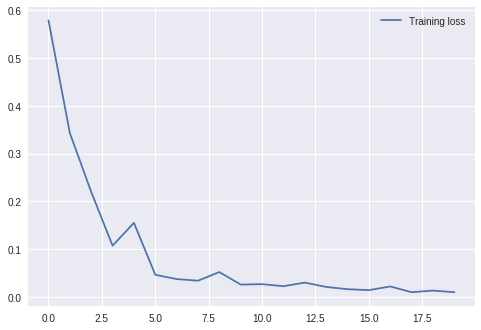

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


PicklingError: ignored

In [0]:
#train the model

running_loss=0
train_losses, test_losses = [], []
model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        running_loss+=loss.item()
        
        #print statements and validation
        if(i+1)%10 ==0:
         #   print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
           #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device),labels.to(device)
                    logps = model.forward(images)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))                    
            print(f"Epoch {epoch+1}/{num_epochs}.. "
                  f"Train loss: {running_loss/10:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()
          

          
          
          
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)
plt.show()     

torch.save(model, 'uploadmodel.pth')


In [0]:
model=torch.load('uploadmodel.pth')
model.eval()

EOFError: ignored

In [0]:
def create_submission(predictions, fname="/drive/My Drive/Colab Notebooks/submission.csv"):
    """
            `predictions` - numpy array of dimension (n_samples,)
    """
    with open(fname, 'w') as f:
        f.write("Id,Category")
        for idx,yhat in enumerate(predictions):
            f.write("\n{},{}".format(idx,yhat))
            
            


In [0]:
predictions=[]
model=torch.load('uploadmodel.pth')
model.eval()

#predict yhat for each datum
for i, (image) in enumerate(test_loader):
  image = image.to(device)
  outputs = model(image)
  values, index = torch.max(outputs, 1)
  index = index.data.cpu().numpy()
  predictions.append(index)
            
#convert it to np array and create the file
predictions=np.asarray(predictions)
predictions=predictions.flatten()
create_submission(predictions)